# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [1]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
from xhistogram.xarray import histogram

In [2]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=20) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [10]:
## Parameters
# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# output figures path
figures_path = Path("reports/figures/ColdBlob/")

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/osnap/') 
filename_tracks = [
                    'tracks_randomvel_osnap_backward_200707_N28923_D1460_Rnd890.nc',
                    'tracks_randomvel_osnap_backward_200707_N14303_D1460_Rnd567.nc',
                    'tracks_randomvel_osnap_backward_200707_N14171_D1460_Rnd123.nc'
]

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/sections/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

#section euleian transport file
transsectionPath = Path('data/processed/sections/')


degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 2375914.29783   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 500 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * (439518+219717+219781) / (528775+264385*2)

particle_section_area = osnap_subsection_length * osnap_subsection_depth / (528775+264385*2)


## Load data

### mesh and masks

In [4]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

### section position data

In [8]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))

In [9]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

### Read in True transport data

In [11]:
transport_37wto0_z200 =xr.open_dataset(project_path / transsectionPath / 'transport_37wto0_z200.nc')
transport_30wto0_z200 =xr.open_dataset(project_path / transsectionPath / 'transport_30wto0_z200.nc')
transport_37wto19w_z200 =xr.open_dataset(project_path / transsectionPath / 'transport_37wto19w_z200.nc')
transport_30wto19w_z200 =xr.open_dataset(project_path / transsectionPath / 'transport_30wto19w_z200.nc')
transport_37wto0_z500 =xr.open_dataset(project_path / transsectionPath / 'transport_37wto0_z500.nc')
transport_30wto0_z500 =xr.open_dataset(project_path / transsectionPath / 'transport_30wto0_z500.nc')
transport_37wto19w_z500 =xr.open_dataset(project_path / transsectionPath / 'transport_37wto19w_z500.nc')
transport_30wto19w_z500 =xr.open_dataset(project_path / transsectionPath / 'transport_30wto19w_z500.nc')
transport_37wto0_z800 =xr.open_dataset(project_path / transsectionPath / 'transport_37wto0_z800.nc')
transport_30wto0_z800 =xr.open_dataset(project_path / transsectionPath / 'transport_30wto0_z800.nc')
transport_37wto19w_z800 =xr.open_dataset(project_path / transsectionPath / 'transport_37wto19w_z800.nc')
transport_30wto19w_z800 =xr.open_dataset(project_path / transsectionPath / 'transport_30wto19w_z800.nc')
transport_37wto0_z1000 =xr.open_dataset(project_path / transsectionPath / 'transport_37wto0_z1000.nc')
transport_30wto0_z1000 =xr.open_dataset(project_path / transsectionPath / 'transport_30wto0_z1000.nc')
transport_37wto19w_z1000 =xr.open_dataset(project_path / transsectionPath / 'transport_37wto19w_z1000.nc')
transport_30wto19w_z1000 =xr.open_dataset(project_path / transsectionPath / 'transport_30wto19w_z1000.nc')


### tracks

In [12]:
for i,filename in enumerate(filename_tracks):
    dst=xr.open_dataset(project_path / path_data_tracks / filename)
    if i == 0:
        ds=dst
    else:
        ds=xr.concat([ds,dst],dim='traj')
        
display(ds)


<xarray.Dataset>
Dimensions:     (obs: 1461, traj: 57397)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 91.0 91.0 91.0 ... 2.643e+05 2.643e+05
    time        (traj, obs) datetime64[ns] 2007-07-16T12:00:00 ... 2003-07-17...
    lat         (traj, obs) float64 60.07 60.11 60.17 ... 57.16 57.14 57.12
    lon         (traj, obs) float64 -42.86 -42.85 -42.83 ... -20.74 -20.74
    z           (traj, obs) float64 138.0 134.4 134.5 ... 83.19 84.23 85.28
    temp        (traj, obs) float32 1.72 1.436 1.58 1.053 ... 11.69 11.68 11.69
    salt        (traj, obs) float32 33.84 33.76 33.83 ... 35.44 35.44 35.44
    uvel        (traj, obs) float32 1.306e-07 -4.205e-07 ... -1.583e-07
    vvel        (traj, obs) float32 -9.459e-07 -1.485e-07 ... 1.81e-07 2.136e-07
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

#### Subset tracks by OSNAP line cross longitude and depth range

In [13]:
lonRange=[-37,0]
depthRange=[0,500]

In [14]:
ds = ds.where(ds.isel(obs=0).lon > lonRange[0]).where(ds.isel(obs=0).lon < lonRange[1])
ds = ds.where(ds.isel(obs=0).z > depthRange[0]).where(ds.isel(obs=0).z < depthRange[1])
ds = ds.dropna('traj', how='all')
    

#### Velocity conversions from degrees lat/lon per second to m/s

In [15]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

#### Extract fields on osnap line (obs=0). Find 'initial' velocities normal to the section.

These are the positions we 'initialised' the particles with, but we ran particles backwards in time so these  represent the final positions, on the osnap line.

In [16]:
ds_init = ds.isel(obs=0)

In [17]:
ds_init = ds_init.assign({'section_index':xr.DataArray(np.searchsorted(lonlat.lon,ds_init.lon)-1,dims='traj')})
ds_init = ds_init.assign({'u_normal':ds_init.vvel_ms * lonlatdiff.costheta[ds_init.section_index].data - ds_init.uvel_ms * lonlatdiff.sintheta[ds_init.section_index].data})
ds_init = ds_init.assign({'u_along':ds_init.vvel_ms * lonlatdiff.sintheta[ds_init.section_index].data + ds_init.uvel_ms * lonlatdiff.costheta[ds_init.section_index].data})


#### Find along-section distances of initial points

In [18]:
ds_init = ds_init.assign({'x':xr.DataArray(length_west[ds_init.section_index] + lonlatdiff.length[ds_init.section_index]*
                              (ds_init.lon - lonlat.lon[ds_init.section_index])/lonlatdiff.lon[ds_init.section_index],dims='traj')})

### volume, temperature and salt transports along track

In [19]:
# at osnap line
ds_init = ds_init.assign({'vol_trans_normal':np.sign(ds_init.u_normal) * particle_section_area/1.0e06})
ds_init = ds_init.assign({'temp_transport':ds_init.temp * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'salt_transport':ds_init.salt * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'depth_transport':ds_init.z * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'lon_transport':ds_init.lon * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'particle_vol':ds_init.vol_trans_normal/ds_init.u_normal})
ds_init = ds_init.assign({'tempxvol':ds_init.temp * ds_init.particle_vol})
ds_init = ds_init.assign({'saltxvol':ds_init.salt * ds_init.particle_vol})
ds_init = ds_init.assign({'depthxvol':ds_init.z * ds_init.particle_vol})
ds_init = ds_init.assign({'lonxvol':ds_init.lon * ds_init.particle_vol})

# full track assuming alongtrack volume transport conserved following particle
ds = ds.assign({'temp_transport':ds.temp * ds_init.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds_init.vol_trans_normal})
ds = ds.assign({'vol_transport':ds_init.vol_trans_normal * ds.salt/ds.salt}) # trick to get full array dimensions

In [20]:
ds_init

<xarray.Dataset>
Dimensions:           (traj: 41018)
Dimensions without coordinates: traj
Data variables: (12/25)
    trajectory        (traj) float64 3.652e+04 3.653e+04 ... 2.64e+05 2.643e+05
    time              (traj) datetime64[ns] 2007-07-16T12:00:00 ... 2007-07-1...
    lat               (traj) float64 59.07 59.07 59.03 ... 56.96 57.09 57.05
    lon               (traj) float64 -33.09 -33.13 -32.67 ... -9.215 -8.787
    z                 (traj) float64 56.92 363.9 18.26 ... 57.39 240.8 109.9
    temp              (traj) float32 8.786 6.423 10.72 ... 11.98 10.45 10.48
    ...                ...
    lon_transport     (traj) float64 -0.03717 -0.03722 ... -0.01035 -0.00987
    particle_vol      (traj) float64 0.004592 0.007104 ... 0.08514 0.3243
    tempxvol          (traj) float64 0.04034 0.04563 0.1445 ... 0.8898 3.4
    saltxvol          (traj) float64 0.1605 0.2488 0.4725 ... 1.502 3.02 11.5
    depthxvol         (traj) float64 0.2614 2.585 0.2461 ... 2.454 20.51 35.65
    lonxvol           (traj) float64 -0.152 -0.2354 -0.4403 ... -0.7846 -2.85
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

In [21]:
ds

<xarray.Dataset>
Dimensions:         (obs: 1461, traj: 41018)
Dimensions without coordinates: obs, traj
Data variables: (12/14)
    trajectory      (traj, obs) float64 3.652e+04 3.652e+04 ... 2.643e+05
    time            (traj, obs) datetime64[ns] 2007-07-16T12:00:00 ... 2003-0...
    lat             (traj, obs) float64 59.07 58.88 58.68 ... 57.16 57.14 57.12
    lon             (traj, obs) float64 -33.09 -33.17 -33.34 ... -20.74 -20.74
    z               (traj, obs) float64 56.92 57.43 57.39 ... 83.19 84.23 85.28
    temp            (traj, obs) float32 8.786 8.84 8.703 ... 11.69 11.68 11.69
    ...              ...
    vvel            (traj, obs) float32 2.206e-06 2.226e-06 ... 2.136e-07
    uvel_ms         (traj, obs) float64 0.02184 0.08059 ... -0.002869 -0.00955
    vvel_ms         (traj, obs) float32 0.2452 0.2474 0.2341 ... 0.02012 0.02373
    temp_transport  (traj, obs) float64 0.009869 0.00993 ... 0.01311 0.01313
    salt_transport  (traj, obs) float64 0.03927 0.03928 ... 0.03981 0.03981
    vol_transport   (traj, obs) float64 0.001123 0.001123 ... 0.001123 0.001123
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

## Plot section

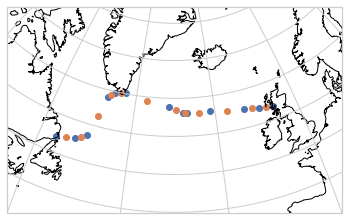

In [22]:
sns.set(style="whitegrid")
central_lon, central_lat = -30, 55
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
extent = [-60, 0, 40, 70]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')

lonlat.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat')
lonlat2mean.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat');

## identify tracks by source region

In [23]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected while they are in a selected area.
    '''
    # particles are selected if they pass through given area.
    position =  ((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                        
    return position > 0.0, position < 0

#### from Labrador sea or from Gulf Stream

In [24]:
# labrador sea
ds_in1, ds_notin1 = apply_left_of_line(ds,-75,-40,40,65)
ds_in2, ds_notin2 = apply_left_of_line(ds,-95,-60,52,52)
ds_lab_sea_in = ds_in1*ds_in2
# 60w
ds_in, ds_notin = apply_left_of_line(ds,-60,-60,33,63)
ds_60w_in = ds_in
# gulf stream
ds_in, ds_notin = apply_left_of_line(ds,-60,-100,33,33)
ds_gs_in = ds_in


In [27]:
# particles on osnap line
ds_init_labsea = ds_init.where(ds_lab_sea_in.max("obs"))
ds_init_60w = ds_init.where((ds_60w_in.max("obs")) & (ds_lab_sea_in.max("obs")))
ds_init_gs = ds_init.where((ds_gs_in.max("obs")) &(ds_lab_sea_in.max("obs")==False))
ds_init_other = ds_init.where((ds_60w_in.max("obs")==False) & (ds_lab_sea_in.max("obs")==False))

# particles throughout tracking timespan
# ds_lab_sea = ds.where(ds_lab_sea_in.max("obs"))
# ds_60w = ds.where(ds_60w_in.max("obs")).where(ds_lab_sea_in.max("obs"))
# ds_gs = ds.where(ds_gs_in.max("obs")).where(ds_lab_sea_in.max("obs")==False)
# ds_other = ds.where(ds_lab_sea_in.max("obs")==False).where(ds_60w_in.max("obs")==False) 

In [28]:
t=[]

for name,group in ds_init.groupby("time"):
    t.append(name)  
    
display(t)


[numpy.datetime64('2007-07-16T12:00:00.000000000')]

#### select by release date

In [42]:
def plot_transports_by_source(ds_i,ds_i_labsea,ds_i_gs,ds_i_other,lonmin,lonmax,z,t,trsp=0):
    
    
    ds_i = ds_i.where((ds_i.time == t) & (ds_i.z < z) & (ds_i.lon < lonmax) & (ds_i.lon > lonmin))
    ds_i_labsea = ds_i_labsea.where((ds_i_labsea.time == t) & (ds_i_labsea.z < z) & (ds_i_labsea.lon < lonmax) & (ds_i_labsea.lon > lonmin))
    ds_i_gs = ds_i_gs.where((ds_i_gs.time == t) & (ds_i_gs.z < z) & (ds_i_gs.lon < lonmax) & (ds_i_gs.lon > lonmin))
    ds_i_other = ds_i_other.where((ds_i_other.time == t) & (ds_i_other.z < z) & (ds_i_other.lon < lonmax) & (ds_i_other.lon > lonmin))

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    plt.rcParams["scatter.marker"] = 'x'
    fig,ax = plt.subplots(figsize = (9,5))
    
    ax.scatter(len(ds_init.traj),ds_init.sum().vol_trans_normal.data,color='C0',label='total')
    ax.scatter(len(ds_init.traj),ds_init_labsea.sum().vol_trans_normal.data,color='C1',label='labrador current')
    ax.scatter(len(ds_init.traj),ds_init_gs.sum().vol_trans_normal.data,color='C2',label='gulf stream')
    ax.scatter(len(ds_init.traj),ds_init_other.sum().vol_trans_normal.data,color='C3',label='other')

    
    ax.scatter(len(ds_init.isel(traj=slice(0,None,2)).traj),2*       ds_init.isel(traj=slice(0,None,2)).sum().vol_trans_normal.data,color='C0')
    ax.scatter(len(ds_init.isel(traj=slice(0,None,2)).traj),2*ds_init_labsea.isel(traj=slice(0,None,2)).sum().vol_trans_normal.data,color='C1')
    ax.scatter(len(ds_init.isel(traj=slice(0,None,2)).traj),2*    ds_init_gs.isel(traj=slice(0,None,2)).sum().vol_trans_normal.data,color='C2')
    ax.scatter(len(ds_init.isel(traj=slice(0,None,2)).traj),2* ds_init_other.isel(traj=slice(0,None,2)).sum().vol_trans_normal.data,color='C3')
    
    ax.scatter(len(ds_init.isel(traj=slice(1,None,4)).traj),4*       ds_init.isel(traj=slice(1,None,4)).sum().vol_trans_normal.data,color='C0')
    ax.scatter(len(ds_init.isel(traj=slice(1,None,4)).traj),4*ds_init_labsea.isel(traj=slice(1,None,4)).sum().vol_trans_normal.data,color='C1')
    ax.scatter(len(ds_init.isel(traj=slice(1,None,4)).traj),4*    ds_init_gs.isel(traj=slice(1,None,4)).sum().vol_trans_normal.data,color='C2')
    ax.scatter(len(ds_init.isel(traj=slice(1,None,4)).traj),4* ds_init_other.isel(traj=slice(1,None,4)).sum().vol_trans_normal.data,color='C3')
    
    ax.scatter(len(ds_init.isel(traj=slice(3,None,8)).traj),8*       ds_init.isel(traj=slice(3,None,8)).sum().vol_trans_normal.data,color='C0')
    ax.scatter(len(ds_init.isel(traj=slice(3,None,8)).traj),8*ds_init_labsea.isel(traj=slice(3,None,8)).sum().vol_trans_normal.data,color='C1')
    ax.scatter(len(ds_init.isel(traj=slice(3,None,8)).traj),8*    ds_init_gs.isel(traj=slice(3,None,8)).sum().vol_trans_normal.data,color='C2')
    ax.scatter(len(ds_init.isel(traj=slice(3,None,8)).traj),8* ds_init_other.isel(traj=slice(3,None,8)).sum().vol_trans_normal.data,color='C3')
    
    ax.scatter(len(ds_init.isel(traj=slice(7,None,16)).traj),16*       ds_init.isel(traj=slice(7,None,16)).sum().vol_trans_normal.data,color='C0')
    ax.scatter(len(ds_init.isel(traj=slice(7,None,16)).traj),16*ds_init_labsea.isel(traj=slice(7,None,16)).sum().vol_trans_normal.data,color='C1')
    ax.scatter(len(ds_init.isel(traj=slice(7,None,16)).traj),16*    ds_init_gs.isel(traj=slice(7,None,16)).sum().vol_trans_normal.data,color='C2')
    ax.scatter(len(ds_init.isel(traj=slice(7,None,16)).traj),16* ds_init_other.isel(traj=slice(7,None,16)).sum().vol_trans_normal.data,color='C3')

    ax.scatter(len(ds_init.isel(traj=slice(15,None,32)).traj),32*       ds_init.isel(traj=slice(15,None,32)).sum().vol_trans_normal.data,color='C0')
    ax.scatter(len(ds_init.isel(traj=slice(15,None,32)).traj),32*ds_init_labsea.isel(traj=slice(15,None,32)).sum().vol_trans_normal.data,color='C1')
    ax.scatter(len(ds_init.isel(traj=slice(15,None,32)).traj),32*    ds_init_gs.isel(traj=slice(15,None,32)).sum().vol_trans_normal.data,color='C2')
    ax.scatter(len(ds_init.isel(traj=slice(15,None,32)).traj),32* ds_init_other.isel(traj=slice(15,None,32)).sum().vol_trans_normal.data,color='C3')

    ax.scatter(len(ds_init.isel(traj=slice(31,None,64)).traj),64*       ds_init.isel(traj=slice(31,None,64)).sum().vol_trans_normal.data,color='C0')
    ax.scatter(len(ds_init.isel(traj=slice(31,None,64)).traj),64*ds_init_labsea.isel(traj=slice(31,None,64)).sum().vol_trans_normal.data,color='C1')
    ax.scatter(len(ds_init.isel(traj=slice(31,None,64)).traj),64*    ds_init_gs.isel(traj=slice(31,None,64)).sum().vol_trans_normal.data,color='C2')
    ax.scatter(len(ds_init.isel(traj=slice(31,None,64)).traj),64* ds_init_other.isel(traj=slice(31,None,64)).sum().vol_trans_normal.data,color='C3')
    
       
    
    ax.axhline(y=trsp)
    
    ax.set_xscale('log')
    
    ax.set_ylim(bottom=0)
    ax.set_ylabel('transport [Sv]')
    ax.set_xlabel('no. of particles')
    
    ax.legend()



    title=fig.suptitle('Transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
           
    return


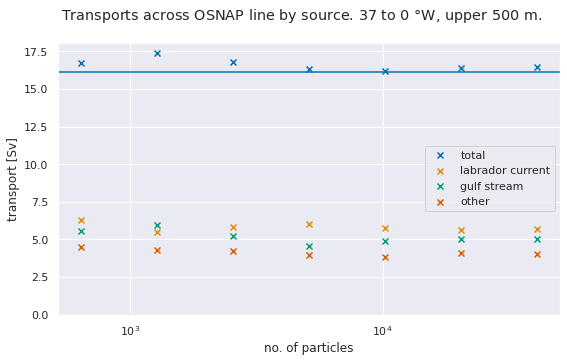

In [43]:
plot_transports_by_source(ds_init,ds_init_labsea,ds_init_gs,ds_init_other,-37,0,1000,t[0],transport_37wto0_z500.sel(time_counter=t[0]).trsp.data)

In [64]:
# conda list